# Optimized PyTorch CNN with Optuna

In this notebook, we optimize a convolutional neural network (CNN) for the CIFAR-10 dataset using Optuna for hyperparameter tuning.

## Notebook set-up

### Imports

In [ ]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from cifar10_tools.pytorch.data import make_data_loaders
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.hyperparameter_optimization import create_cnn, create_objective
from cifar10_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves, plot_optimization_results
)
from cifar10_tools.pytorch.training import train_model

# Suppress Optuna info messages (show only warnings and errors)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Fixed hyperparameters

In [ ]:
# Optuna settings
run_optimization = True  # Run optimization or load results from disk for evaluation
start_new_study = True   # Clear previous results (if any) and start new study or resume 
n_trials = 200           # Number of optimization trials
n_epochs_per_trial = 50  # Epochs per trial
n_epochs_final = 50      # Epochs for final model training
print_every = 5          # Print training progress every n epochs

# SQLite storage for Optuna (local file)
data_dir = Path('../data/pytorch')
data_dir.mkdir(parents=True, exist_ok=True)
storage_path = data_dir / 'cnn_optimization.db'
storage_url = f'sqlite:///{storage_path}'

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Visualize CIFAR-10 sample images

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes.

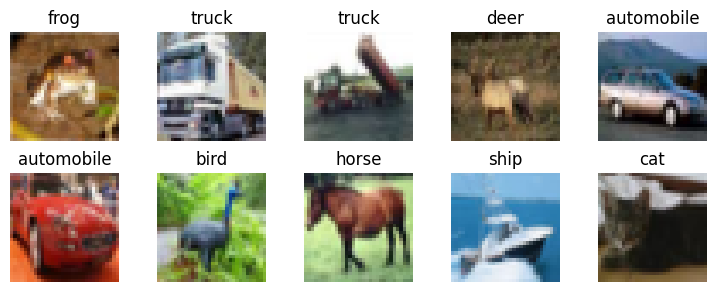

In [ ]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Define transform (RGB)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Get a sample dataset for visualization
sample_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=transform
)

# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(sample_dataset, class_names)
plt.show()

## 2. Optuna hyperparameter optimization

We use `create_objective()` to generate an objective function that Optuna will optimize.
The function samples hyperparameters, creates and trains a model, and returns validation accuracy.

In [ ]:
# Create objective function for Optuna
objective = create_objective(
    data_dir=data_dir,
    train_transform=transform,
    eval_transform=transform,
    n_epochs=n_epochs_per_trial,
    device=device,
    num_classes=num_classes
)

In [ ]:
%%time

if run_optimization:
    print('Running hyperparameter optimization...')

    # Delete existing study if desired & it exists
    if start_new_study == True:
        try:
            optuna.delete_study(study_name='cnn_optimization', storage=storage_url)
            print('Deleted existing study')

        except KeyError:
            print('No existing study found')

    # Create Optuna study with SQLite storage (maximize validation accuracy)
    study = optuna.create_study(
        direction='maximize',
        study_name='cnn_optimization',
        storage=storage_url,
        load_if_exists=True,  # Resume if study already exists
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    print(f'Study stored at: {storage_path}')

    # Run optimization
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

else:

    # Load results from disk
    study = optuna.load_study(
        study_name='cnn_optimization',
        storage=storage_url
    )

    print(f'Study loaded from: {storage_path}')

print(f'\nBest validation accuracy: {study.best_trial.value:.2f}%')

for key, value in study.best_trial.params.items():
    print(f' - {key}: {value}')

print()

Study loaded from: ../data/pytorch/cnn_optimization.db

Best trial:
  Value (validation accuracy): 87.96%
  Params:
    n_conv_blocks: 3
    initial_filters: 128
    fc_units_1: 2048
    fc_units_2: 256
    dropout_rate: 0.30468763769815355
    use_batch_norm: True
    learning_rate: 0.04674148624351197
    optimizer: SGD
    sgd_momentum: 0.8921035323388053

CPU times: user 478 ms, sys: 32 ms, total: 510 ms
Wall time: 509 ms


### 2.2. Visualize optimization results

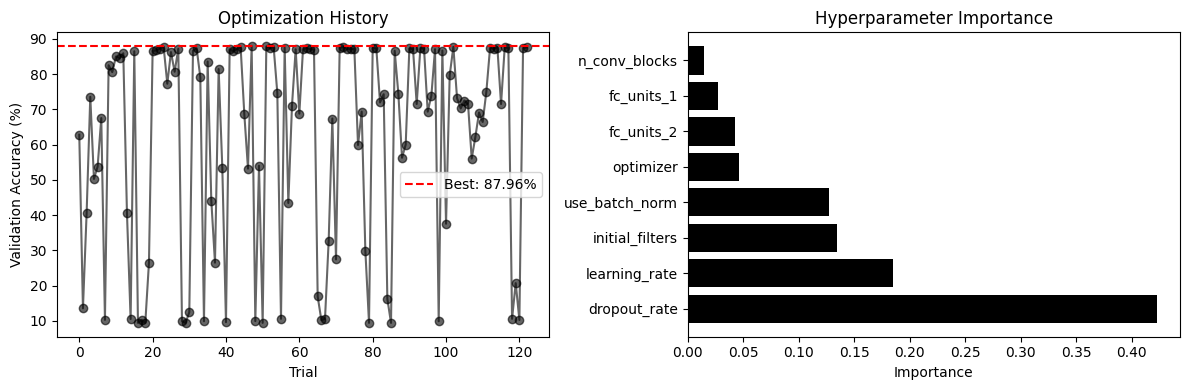

In [9]:
fig, axes = plot_optimization_results(study)
plt.show()

## 3. Train final model with best hyperparameters

### 3.1. Create optimized model

In [ ]:
# Extract best hyperparameters
best_params = study.best_trial.params

print('Best hyperparameters:')
for key, value in best_params.items():
    print(f'  {key}: {value}')

# Recreate data loaders with best batch size
best_batch_size = best_params['batch_size']
train_loader, val_loader, test_loader = make_data_loaders(
    data_dir=data_dir,
    batch_size=best_batch_size,
    train_transform=transform,
    eval_transform=transform,
    device=device
)

print(f'\nRecreated data loaders with batch size: {best_batch_size}')

# Create model with best hyperparameters
best_model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    n_fc_layers=best_params['n_fc_layers'],
    base_kernel_size=best_params['base_kernel_size'],
    conv_dropout_rate=best_params['conv_dropout_rate'],
    fc_dropout_rate=best_params['fc_dropout_rate'],
    pooling_strategy=best_params['pooling_strategy'],
    use_batch_norm=best_params['use_batch_norm']
).to(device)

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

elif best_params['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9)
    )

print(f'\nTotal parameters: {trainable_params}')

else:  # RMSpropprint(best_model)

    best_optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)

# Set cross-entropy loss# Get total trainable parameters

criterion = torch.nn.CrossEntropyLoss()

Best hyperparameters:
  n_conv_blocks: 3
  initial_filters: 128
  fc_units_1: 2048
  fc_units_2: 256
  dropout_rate: 0.30468763769815355
  use_batch_norm: True
  learning_rate: 0.04674148624351197
  optimizer: SGD
  sgd_momentum: 0.8921035323388053

Total parameters: 21886346


### 3.2. Train optimized model

In [11]:
%%time

history = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=best_optimizer,
    epochs=n_epochs_final,
    print_every=print_every
)

Epoch 1/50 - loss: 1.7986 - accuracy: 31.75% - val_loss: 1.8921 - val_accuracy: 32.26%
Epoch 5/50 - loss: 0.7837 - accuracy: 72.31% - val_loss: 0.8239 - val_accuracy: 71.45%
Epoch 10/50 - loss: 0.4828 - accuracy: 83.29% - val_loss: 0.5996 - val_accuracy: 80.19%
Epoch 15/50 - loss: 0.3304 - accuracy: 88.33% - val_loss: 0.5278 - val_accuracy: 83.02%
Epoch 20/50 - loss: 0.2228 - accuracy: 92.00% - val_loss: 0.4902 - val_accuracy: 85.36%
Epoch 25/50 - loss: 0.1514 - accuracy: 94.52% - val_loss: 0.5483 - val_accuracy: 84.82%
Epoch 30/50 - loss: 0.1141 - accuracy: 95.98% - val_loss: 0.5382 - val_accuracy: 86.49%
Epoch 35/50 - loss: 0.0756 - accuracy: 97.39% - val_loss: 0.5969 - val_accuracy: 86.73%
Epoch 40/50 - loss: 0.0548 - accuracy: 98.12% - val_loss: 0.7335 - val_accuracy: 85.44%
Epoch 45/50 - loss: 0.0464 - accuracy: 98.43% - val_loss: 0.6506 - val_accuracy: 86.96%
Epoch 50/50 - loss: 0.0375 - accuracy: 98.68% - val_loss: 0.5930 - val_accuracy: 88.03%

Training complete.
CPU times: use

### 3.3. Learning curves

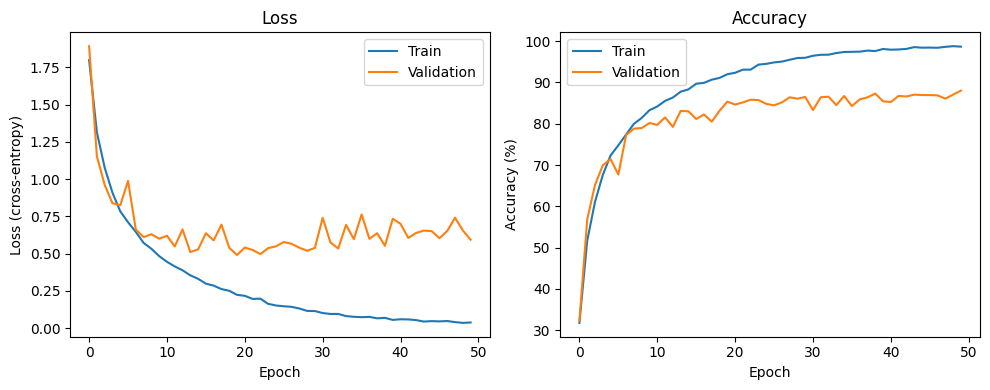

In [12]:
fig, axes = plot_learning_curves(history)
plt.show()

## 4. Evaluate optimized model on test set

### 4.1. Calculate test accuracy

In [13]:
test_accuracy, predictions, true_labels = evaluate_model(best_model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 87.31%


### 4.2. Per-class accuracy

In [14]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 90.20%
automobile  : 93.80%
bird        : 81.10%
cat         : 74.40%
deer        : 86.40%
dog         : 78.60%
frog        : 90.80%
horse       : 90.10%
ship        : 95.20%
truck       : 92.50%


### 4.3. Confusion matrix

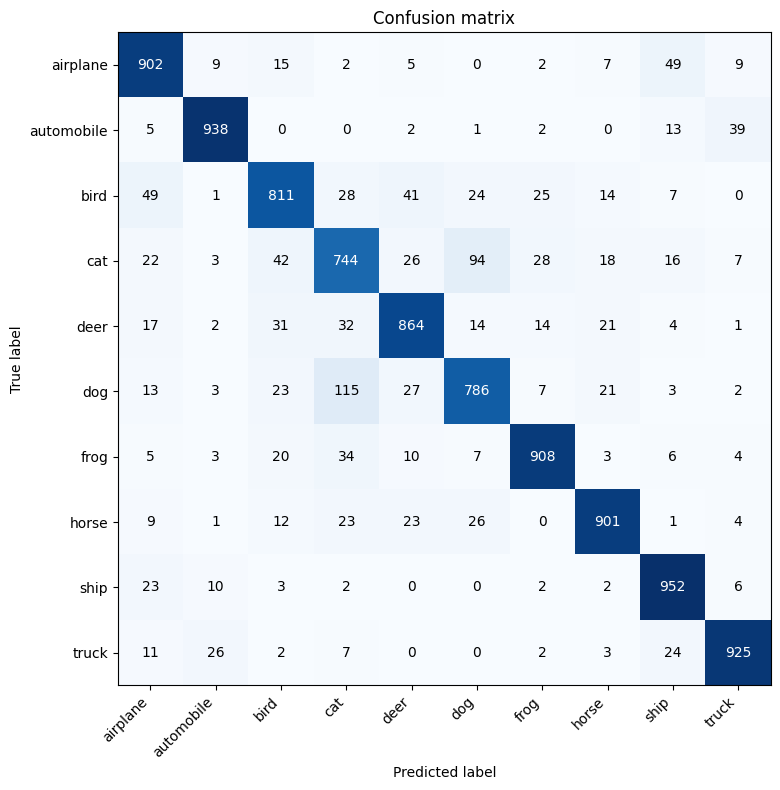

In [15]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 4.4. Predicted class probability distributions

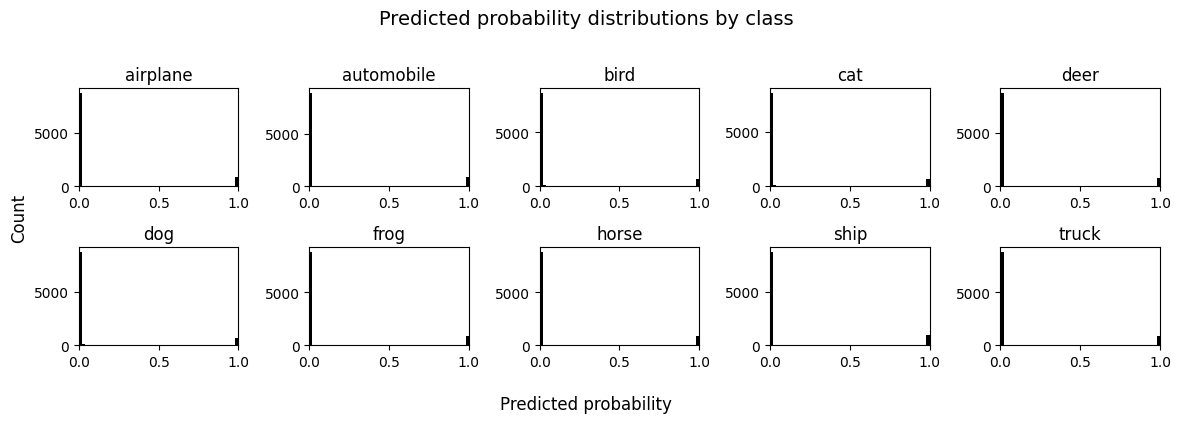

In [16]:
# Get predicted probabilities for all test samples
best_model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 4.5. Evaluation curves

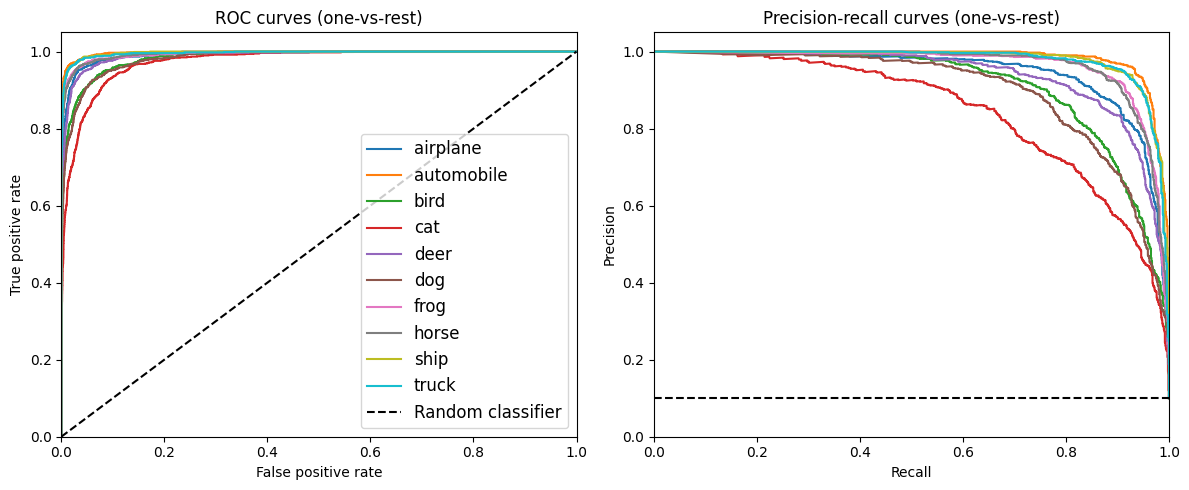

In [17]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 5. Save optimized model and hyperparameters

In [18]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'optimized_cnn.pth'

torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': best_optimizer.state_dict(),
    'best_params': best_params,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/optimized_cnn.pth
Test accuracy: 87.31%
